# FLoC Cohorts from sessions data for panels stratified on race 

What are the right cohort sizes to use?

Precompute simhash and cohorts for panel samples.

The cohort assignments are saved to an output file.

We also generate a comparison cohort assignment file.
- this is used to represent expected results if domains visited / cohorts assigned did not correlate with demographics.
- weekly domains visited are randomly assigned to samples (based on real distribution)
- cohorts are assigned using the same algorithm and parameters as for the real data

In [1]:
from datetime import datetime
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import floc

from comscore.data import read_weeks_machines_domains
import prefixLSH


## Precompute panel samples simhash

read in pre-processed sessions data

In [ ]:
# read in the pre-processed sessions data 
# this maps week,machine_id -> domains set
weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'
weeks_machines_domains_df = read_weeks_machines_domains(weeks_machines_domains_fpath)
weeks_machines_domains_df.drop(['domains'], axis=1).head()

___

read in panels that were created based on the sessions data and demographic data

attach domains data

attach the simhash computed from the domains

precompute cohorts for each panel

In [ ]:
comscore_acs_race_panels_fpath = '../output/comscore_acs_race_panels.csv'
all_panels_df = pd.read_csv(comscore_acs_race_panels_fpath)
print('read in all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())
all_panels_df.drop(['machine_id'], axis=1).head()

In [4]:
weeks_machines_domains = weeks_machines_domains_df.set_index(['machine_id','week'])['domains']
all_panels_df['domains'] = all_panels_df.set_index(['machine_id','week']).index.map(weeks_machines_domains)
all_panels_df.drop(['machine_id','domains'], axis=1).head()

,week,n_domains,racial_background,stratify,panel_id
0,1,76,1.0,1,1
1,1,22,1.0,1,1
2,1,209,1.0,1,1
3,1,17,1.0,1,1
4,1,7,1.0,1,1


In [5]:
# apply simhash
all_panels_df['simhash'] = all_panels_df.domains.apply(floc.hashes.sim_hash_string)

#### Save intermediary output: panels with simhash

Note: dropping domains here is a huge space efficiency gain.

In [ ]:
comscore_acs_race_panels_simhash_fpath = '../output/comscore_acs_race_panels_simhash.csv'

In [7]:
print('saving to %s...' % comscore_acs_race_panels_simhash_fpath)
all_panels_df.drop('domains', axis=1).to_csv(comscore_acs_race_panels_simhash_fpath, index=False)

saving to ../output/comscore_acs_race_panels_simhash.csv...


#### Script re-entry point

In [ ]:
all_panels_df = pd.read_csv(comscore_acs_race_panels_simhash_fpath)
print('read in all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())

## Pre-compute cohorts for each panel

each sample's cohort is dependent on the rest of the simhashes in the panel

for this reason, cohorts must be computed per panel

In [64]:
# some helper functions for plotting
import math

dpi = 100
t = 0.1

race_values = {1:'white', 2:'black', 3:'asian', 5:'other'}


def get_cohort_demo_portions_df(panel_df, demo_col, cohort_name='cohort'):
    df = panel_df.groupby(
        [cohort_name, demo_col]
    ).count()['panel_id'].rename('count').to_frame().reset_index(demo_col)
    df['total'] = panel_df.groupby(cohort_name).count()['panel_id']
    df['portion'] = df['count']/df['total']
    return df


def plot_cohort_demo_fractions(panel_df, demo_col, demo_value_names_dict, cohort_name='cohort', 
                               ncols=4, print=False):
    
    nrows = math.ceil(len(demo_value_names_dict)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), dpi=dpi)
    axes = axes.flatten()
    axes[0].set_ylabel('fraction')
    fig.tight_layout()

    cohort_demo_portions_df = get_cohort_demo_portions_df(
        panel_df, demo_col, cohort_name=cohort_name)
    demo_fractions = panel_df.groupby(demo_col)['panel_id'].count() / len(panel_df)
    
    for i, (val,name) in enumerate(demo_value_names_dict.items()):
        ax = axes[i]
        cohort_demo_mean = cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.mean()
        # Google's sensitivity analysis actually looked at avg for sensitive categories
        # across all users rather than across cohorts
        demo_fraction = demo_fractions[val]
        if print:
            print('mean fraction %s across cohorts = %0.2f' % (name, cohort_demo_mean))
            print('fraction %s across all users in cohorts = %0.2f' % (name, demo_fraction))
        cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.sort_values(ascending=False).plot.bar(ax=ax, label="")
        ax.hlines(y=demo_fraction, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='-', color='black', label='mean')
        ax.hlines(y=demo_fraction+t, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='--', color='black', label='mean + t=0.1')
        ax.set_xticks([])
        ax.set_xlabel('cohorts')
        #ax.set_ylabel('fraction "%s"' % name)
        ax.set_title(name)
    plt.show()
    return cohort_demo_portions_df

### Comparing values of k for cohort creation

What is a good size of k to use? The Google Chrome origin trial (OT) used k=2000 but with much larger samples than our panel.

It is important for there to be enough cohorts in order to separate the browsing histories.

e.g. for the extreme example, if we were to use k=2000 but only have 8 cohorts, then users that exhibit what would be considered very different browsing behaviors if there were more cohorts, such as in the OT trial, may instead be grouped into the same cohort. 

Here we compare various values of k before choosing values to precompute cohorts for.

In [10]:
33872 / 2000

16.936


For the OT, the number of cohorts was 33,872. i.e. More than 16.5x the minimum k.

Should we try to use a similar ratio of `k : |C| = 2 : 33.9` ?

In [11]:
panel_id = 2 # looked at various panel IDs
panel_df = all_panels_df[all_panels_df.panel_id==panel_id].copy()
print('using panel id %s' % panel_id)

using panel id 2


In [62]:
def show_panel_info(panel_df, cohort_name='cohort'):
    print('%s total cohorts' % panel_df[cohort_name].nunique())
    print('|C| / k = %0.3f' % (panel_df[cohort_name].nunique()/k))
    
    print('cohort sizes:')
    cohort_counts = panel_df[cohort_name].value_counts()
    print(cohort_counts.describe())

    fig,ax = plt.subplots(2,1,figsize=(4,3), sharex=True, dpi=100)
    cohort_counts.hist(ax=ax[0])
    ax[0].set_ylabel('cohorts')
    ax[1].set_ylabel('cohorts')
    _ = ax[1].set_xlabel('cohort size')
    _ = cohort_counts.hist(ax=ax[1], bins=50)
    
    _ = plot_cohort_demo_fractions(panel_df, 'racial_background', race_values, cohort_name=cohort_name)


k=2000 ---------------------------

8 total cohorts
|C| / k = 0.004
cohort sizes:
count       8.000000
mean     3291.750000
std       627.483807
min      2532.000000
25%      2786.500000
50%      3133.000000
75%      3879.750000
max      4151.000000
Name: cohort, dtype: float64


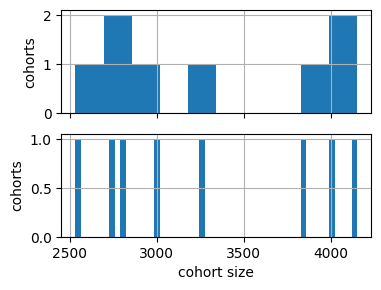

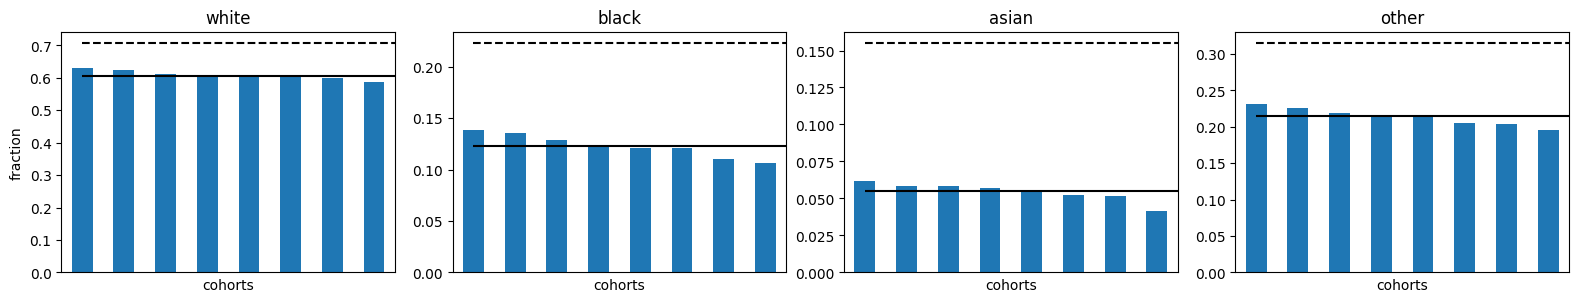


k=1000 ---------------------------

17 total cohorts
|C| / k = 0.017
cohort sizes:
count      17.000000
mean     1549.058824
std       480.768197
min      1083.000000
25%      1246.000000
50%      1377.000000
75%      1720.000000
max      2737.000000
Name: cohort, dtype: float64


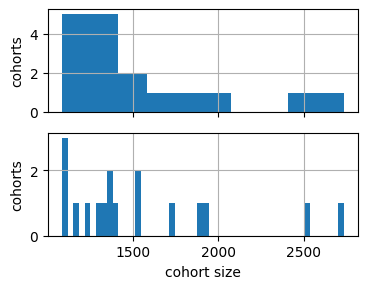

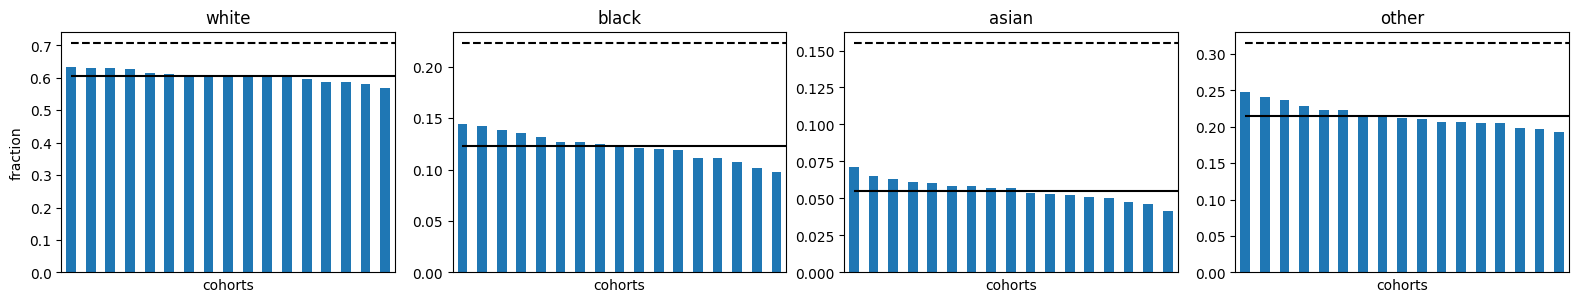


k=500 ---------------------------

33 total cohorts
|C| / k = 0.066
cohort sizes:
count      33.000000
mean      798.000000
std       191.622839
min       529.000000
25%       643.000000
50%       796.000000
75%       925.000000
max      1246.000000
Name: cohort, dtype: float64


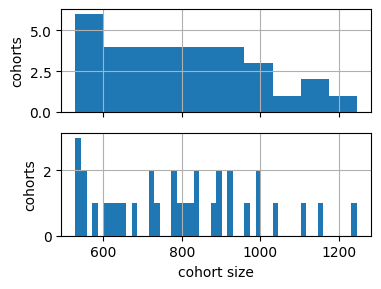

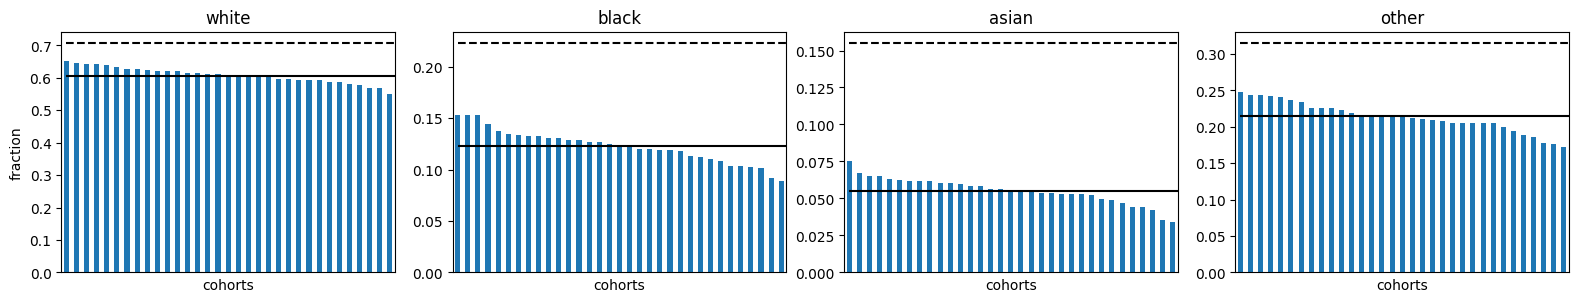


k=250 ---------------------------

66 total cohorts
|C| / k = 0.264
cohort sizes:
count     66.000000
mean     399.000000
std       97.485936
min      252.000000
25%      315.250000
50%      371.500000
75%      484.000000
max      610.000000
Name: cohort, dtype: float64


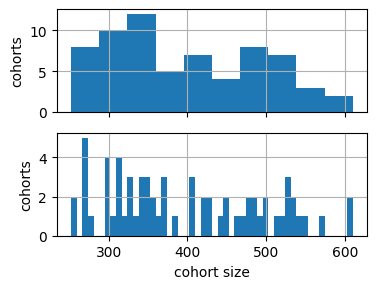

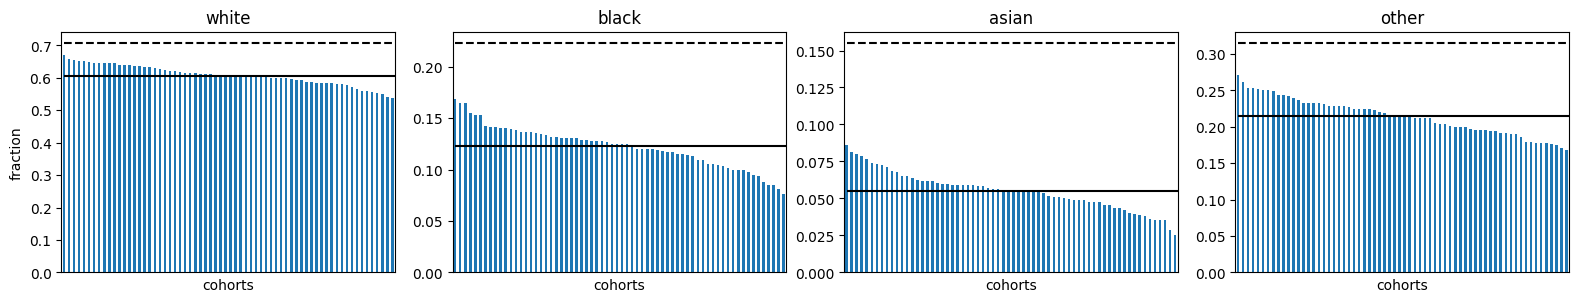


k=125 ---------------------------

142 total cohorts
|C| / k = 1.136
cohort sizes:
count    142.000000
mean     185.450704
std       43.219312
min      125.000000
25%      149.500000
50%      182.000000
75%      213.750000
max      313.000000
Name: cohort, dtype: float64


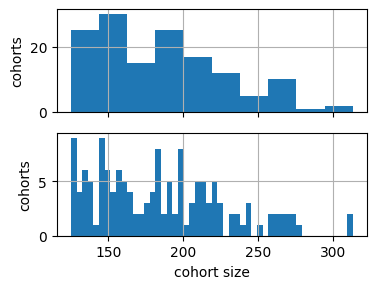

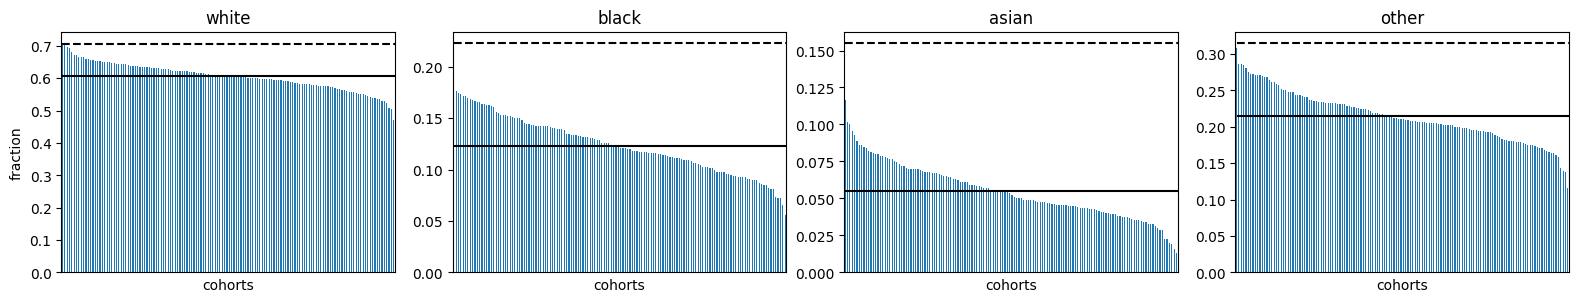


k=100 ---------------------------

168 total cohorts
|C| / k = 1.680
cohort sizes:
count    168.000000
mean     156.750000
std       36.567508
min      100.000000
25%      127.000000
50%      151.000000
75%      185.000000
max      268.000000
Name: cohort, dtype: float64


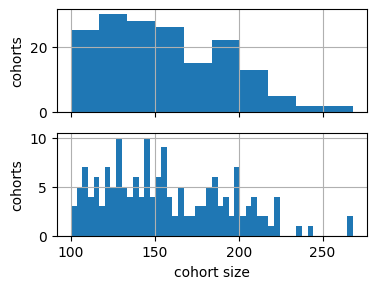

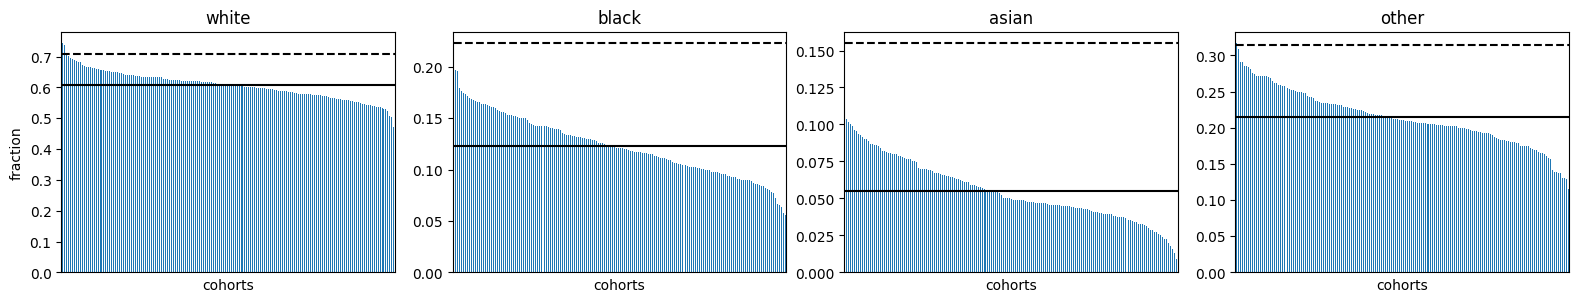


k=50 ---------------------------

311 total cohorts
|C| / k = 6.220
cohort sizes:
count    311.000000
mean      84.675241
std       25.334803
min       50.000000
25%       65.000000
50%       80.000000
75%       98.500000
max      214.000000
Name: cohort, dtype: float64


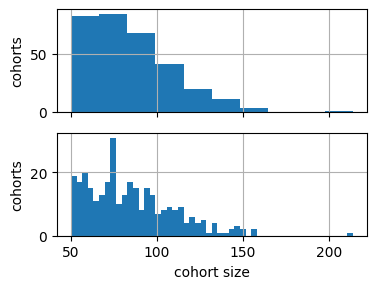

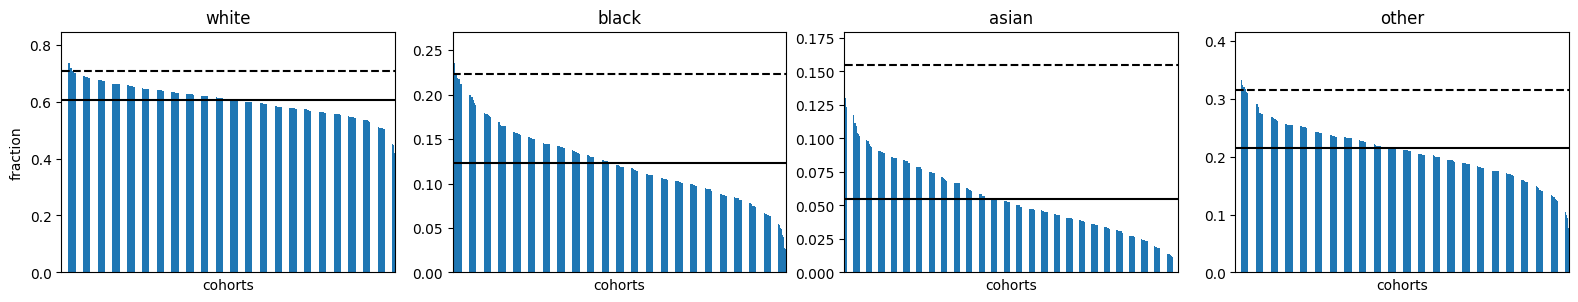


k=40 ---------------------------

397 total cohorts
|C| / k = 9.925
cohort sizes:
count    397.000000
mean      66.332494
std       19.482452
min       40.000000
25%       51.000000
50%       64.000000
75%       79.000000
max      151.000000
Name: cohort, dtype: float64


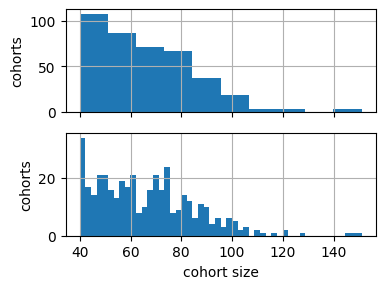

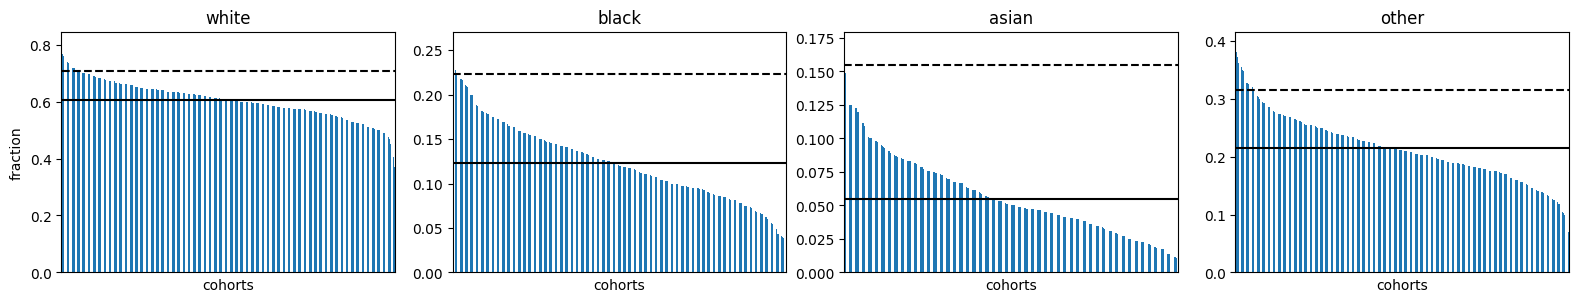


k=35 ---------------------------

467 total cohorts
|C| / k = 13.343
cohort sizes:
count    467.000000
mean      56.389722
std       16.235199
min       35.000000
25%       42.000000
50%       54.000000
75%       67.000000
max      122.000000
Name: cohort, dtype: float64


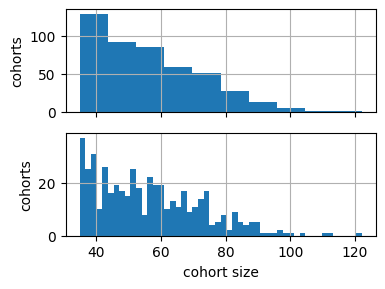

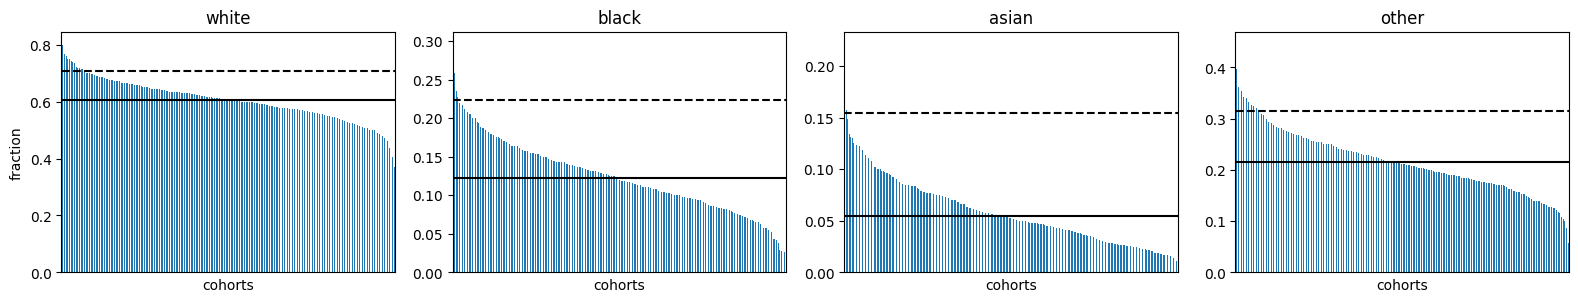


k=32 ---------------------------

509 total cohorts
|C| / k = 15.906
cohort sizes:
count    509.000000
mean      51.736739
std       15.126027
min       32.000000
25%       39.000000
50%       49.000000
75%       61.000000
max      122.000000
Name: cohort, dtype: float64


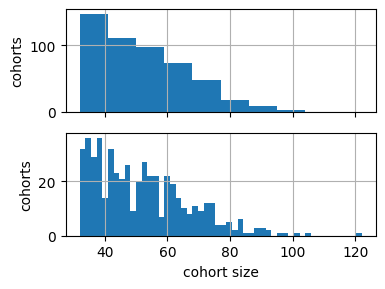

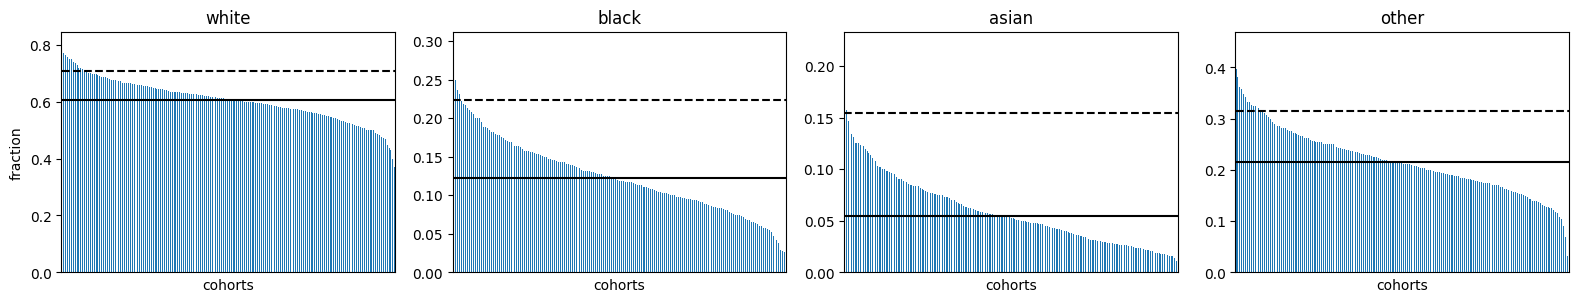


k=31 ---------------------------

531 total cohorts
|C| / k = 17.129
cohort sizes:
count    531.000000
mean      49.593220
std       14.363485
min       31.000000
25%       38.000000
50%       47.000000
75%       59.000000
max      122.000000
Name: cohort, dtype: float64


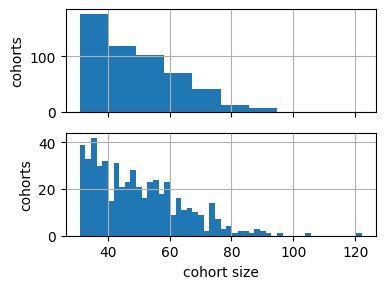

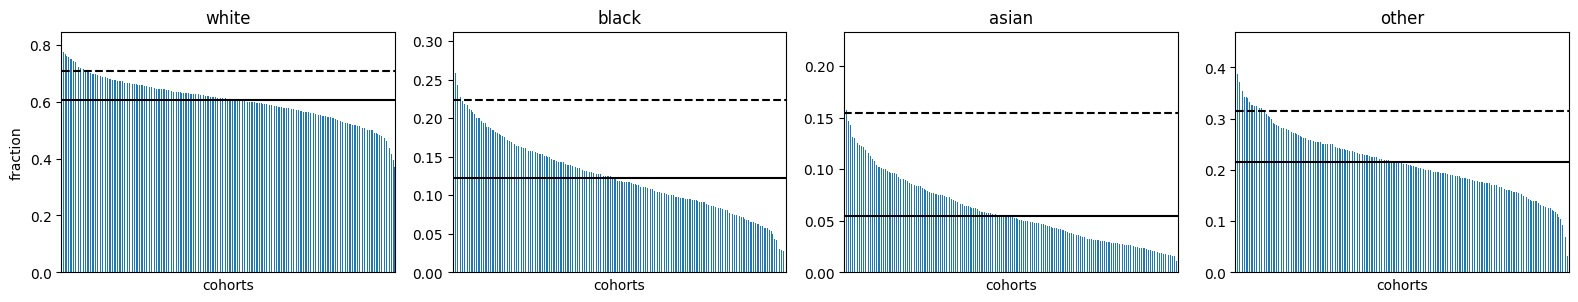


k=30 ---------------------------

547 total cohorts
|C| / k = 18.233
cohort sizes:
count    547.000000
mean      48.142596
std       14.095753
min       30.000000
25%       37.000000
50%       46.000000
75%       56.500000
max      122.000000
Name: cohort, dtype: float64


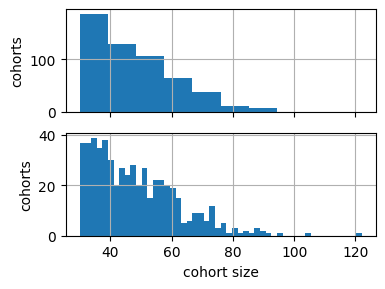

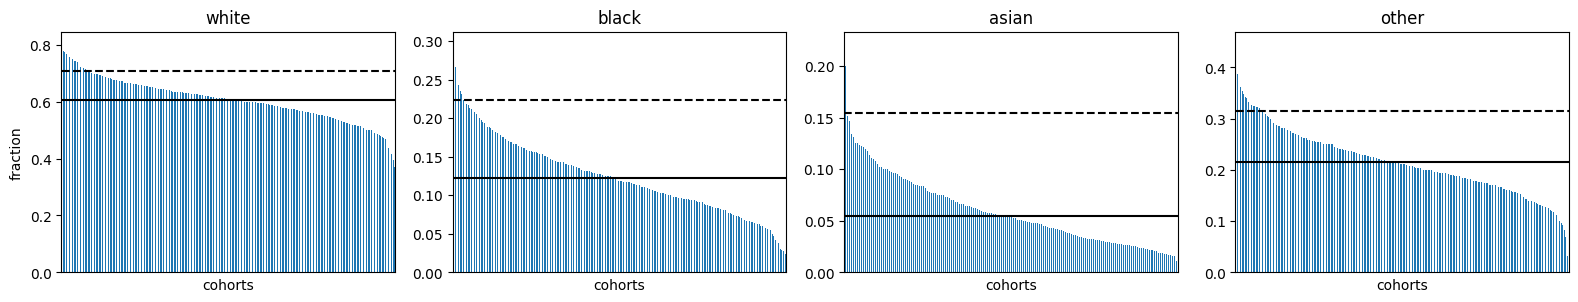

In [13]:
k_values = [2000, 1000, 500, 250, 125, 100, 50, 40, 35, 32, 31, 30]

for k in k_values:
    print('\nk=%s ---------------------------\n' % k)
    cohorts_dict = prefixLSH.get_cohorts_dict(panel_df.simhash.astype(int), min_k=k)
    panel_df['cohort'] = panel_df.simhash.map(cohorts_dict)
    show_panel_info(panel_df)
    

## Precompute cohorts

Using cohort size of k = 32 (in order to best match the OT ratio for k:|C|)

In [52]:
# computing cohort IDs for panels in parallel jobs
# since each panel's data is independent for cohort computation
# and this is slow...

from joblib import Parallel, delayed

N_JOBS = 5
k = 32

In [ ]:
panel_ids = all_panels_df.panel_id.unique()

In [53]:
def assign_cohorts(panels_df, panel_id, k=k, cohort_name='cohort'):
    panel_df = panels_df[panels_df.panel_id==panel_id].copy()
    panel_df[cohort_name] = np.nan # preset all cohorts to None
    cohorts_dict = prefixLSH.get_cohorts_dict(panel_df.simhash.astype(int), min_k=k)
    assign_cohort = lambda x: cohorts_dict[x.simhash] if x.panel_id == panel_id else x[cohort_name]
    panel_df[cohort_name] = panel_df.apply(assign_cohort, axis=1)
    return panel_df

In [16]:
panel_dfs = Parallel(n_jobs=N_JOBS, verbose=True)(delayed(assign_cohorts)(
    all_panels_df, panel_id, k=k) for panel_id in panel_ids)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   13.9s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   46.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  2.0min finished


Check this looks okay

In [17]:
print(len(panel_dfs))

520


In [18]:
all_panels_cohort_df = pd.concat(panel_dfs)
all_panels_cohort_df.head()

,machine_id,week,n_domains,racial_background,stratify,panel_id,simhash,cohort
0,216368766,1,76,1.0,1,1,365749827549635,156
1,225562713,1,22,1.0,1,1,207360132440987,90
2,193448730,1,209,1.0,1,1,298786899639816,125
3,216306558,1,17,1.0,1,1,463655815244049,192
4,223440886,1,7,1.0,1,1,308745029242759,128


499 total cohorts
|C| / k = 15.594
cohort sizes:
count    499.00000
mean      51.98998
std       15.86723
min       32.00000
25%       39.00000
50%       48.00000
75%       62.00000
max      118.00000
Name: cohort, dtype: float64


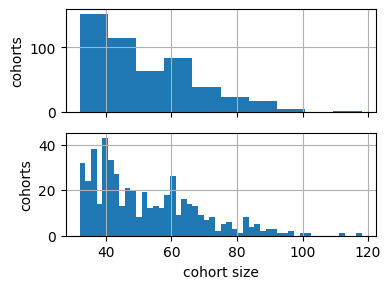

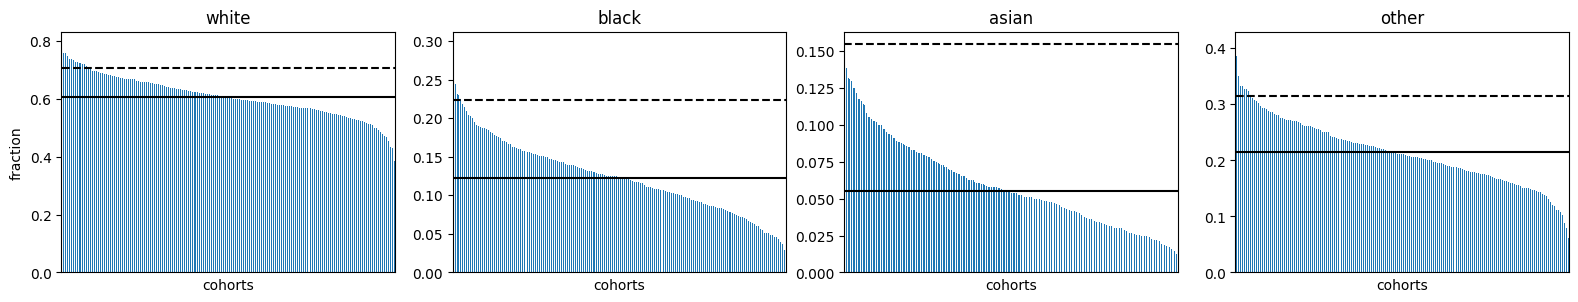

In [19]:
panel_df = all_panels_cohort_df[all_panels_cohort_df.panel_id==4]
show_panel_info(panel_df)

Also compute cohort IDs for other k, for experimentation later

In [20]:
# iteratively add more cohort id values for each k in new column, for each panel
k_values = [30, 32, 35, 40, 50, 100]

for k in k_values:
    cohort_name = 'cohort_k%s'%k
    print('assigning cohorts for k=%s (%s)' % (k, cohort_name))
    panel_dfs = Parallel(n_jobs=N_JOBS, verbose=True)(delayed(assign_cohorts)(
        all_panels_cohort_df, panel_id, k=k, cohort_name=cohort_name) for panel_id in panel_ids)
    all_panels_cohort_df = pd.concat(panel_dfs)

assigning cohorts for k=30 (cohort_k30)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   10.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   45.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  2.0min finished


assigning cohorts for k=32 (cohort_k32)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   32.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  4.7min finished


assigning cohorts for k=35 (cohort_k35)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   26.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  4.9min finished


assigning cohorts for k=40 (cohort_k40)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   28.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.6min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  5.3min finished


assigning cohorts for k=50 (cohort_k50)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   33.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.9min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  5.8min finished


assigning cohorts for k=100 (cohort_k100)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   36.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  5.2min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  6.1min finished


In [21]:
all_panels_cohort_df.head()

,machine_id,week,n_domains,racial_background,stratify,panel_id,simhash,cohort,cohort_k30,cohort_k32,cohort_k35,cohort_k40,cohort_k50,cohort_k100
0,216368766,1,76,1.0,1,1,365749827549635,156,170,156,137,120,92,52
1,225562713,1,22,1.0,1,1,207360132440987,90,97,90,80,71,52,31
2,193448730,1,209,1.0,1,1,298786899639816,125,137,125,111,97,73,43
3,216306558,1,17,1.0,1,1,463655815244049,192,207,192,169,144,113,64
4,223440886,1,7,1.0,1,1,308745029242759,128,141,128,114,100,76,45


inspecting panel id = 379

-----------
k=30

525 total cohorts
|C| / k = 17.500
cohort sizes:
count    525.000000
mean      48.148571
std       13.379688
min       30.000000
25%       37.000000
50%       46.000000
75%       57.000000
max      104.000000
Name: cohort_k30, dtype: float64


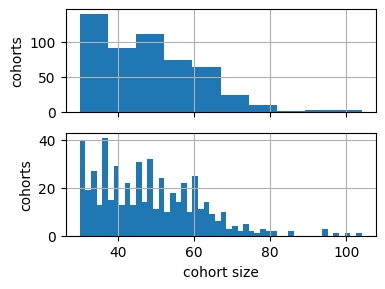

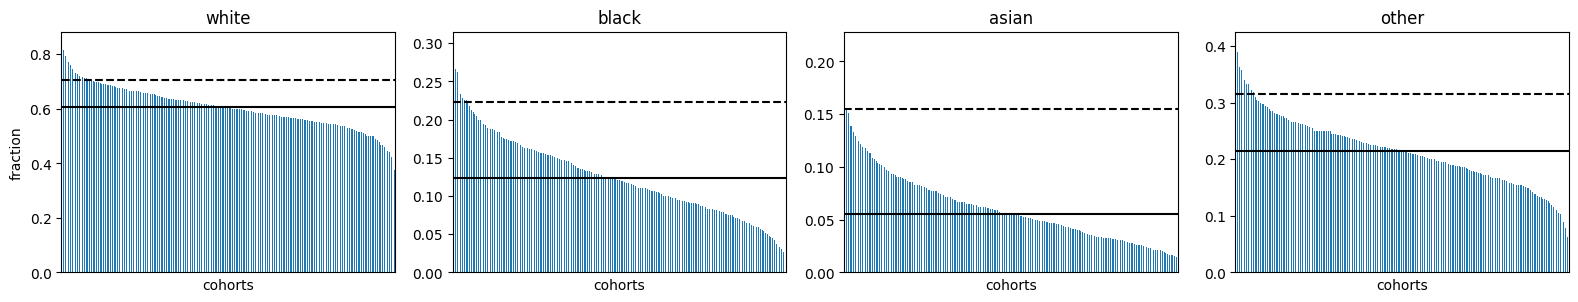


-----------
k=32

485 total cohorts
|C| / k = 15.156
cohort sizes:
count    485.000000
mean      52.119588
std       14.257017
min       32.000000
25%       40.000000
50%       50.000000
75%       61.000000
max      104.000000
Name: cohort_k32, dtype: float64


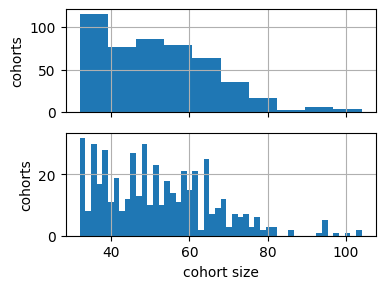

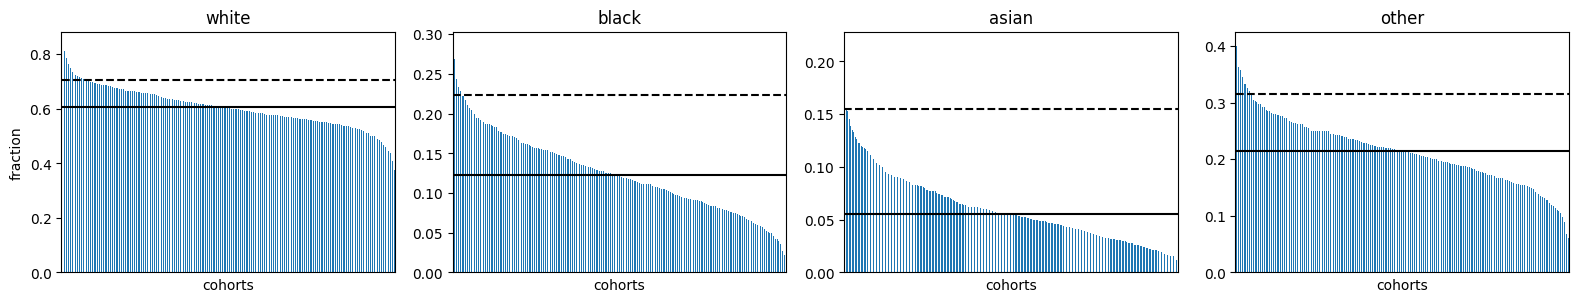


-----------
k=35

447 total cohorts
|C| / k = 12.771
cohort sizes:
count    447.000000
mean      56.550336
std       15.321855
min       35.000000
25%       45.000000
50%       55.000000
75%       66.000000
max      104.000000
Name: cohort_k35, dtype: float64


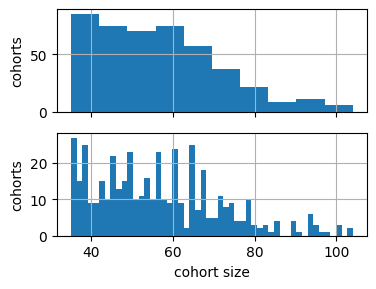

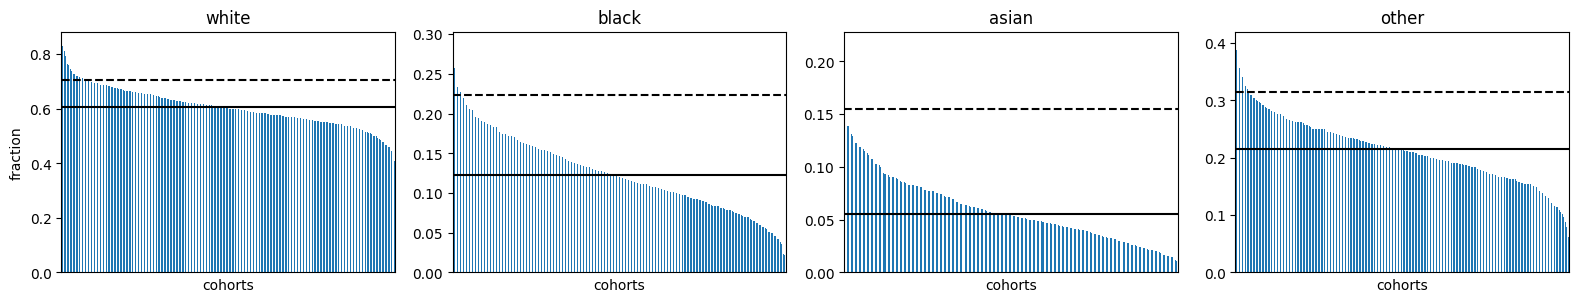


-----------
k=40

388 total cohorts
|C| / k = 9.700
cohort sizes:
count    388.000000
mean      65.149485
std       17.455986
min       40.000000
25%       51.000000
50%       62.000000
75%       76.250000
max      125.000000
Name: cohort_k40, dtype: float64


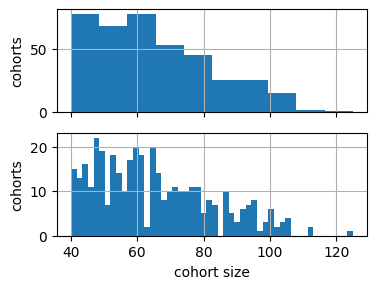

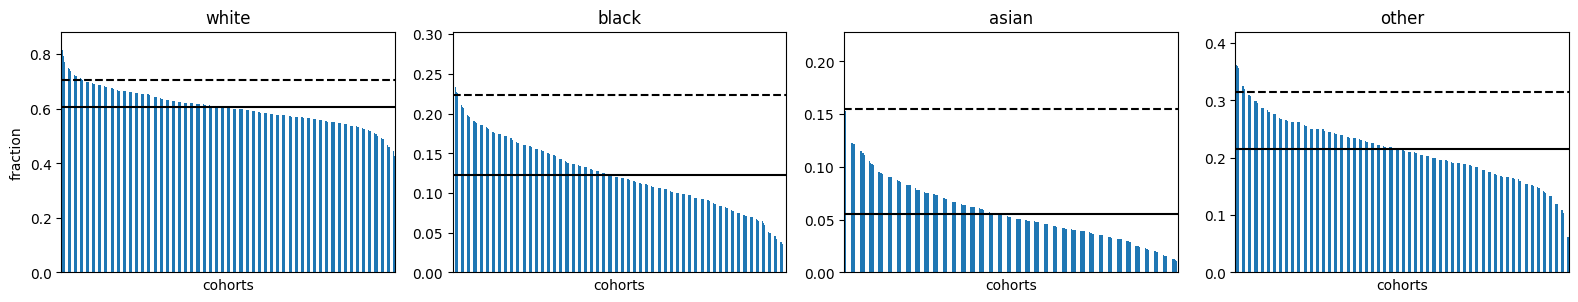


-----------
k=50

310 total cohorts
|C| / k = 6.200
cohort sizes:
count    310.000000
mean      81.541935
std       22.226035
min       50.000000
25%       64.000000
50%       78.500000
75%       97.000000
max      165.000000
Name: cohort_k50, dtype: float64


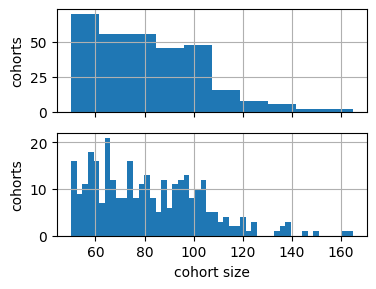

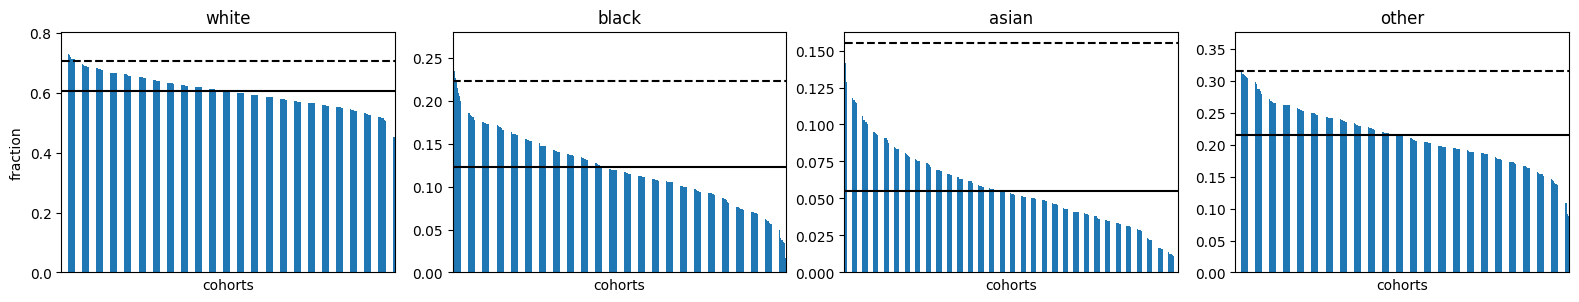


-----------
k=100

163 total cohorts
|C| / k = 1.630
cohort sizes:
count    163.000000
mean     155.079755
std       37.434549
min      100.000000
25%      127.500000
50%      148.000000
75%      179.500000
max      260.000000
Name: cohort_k100, dtype: float64


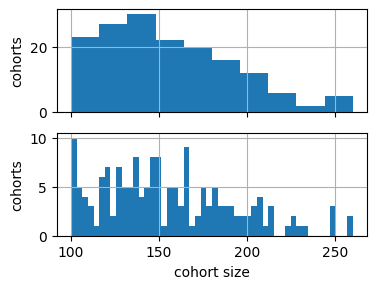

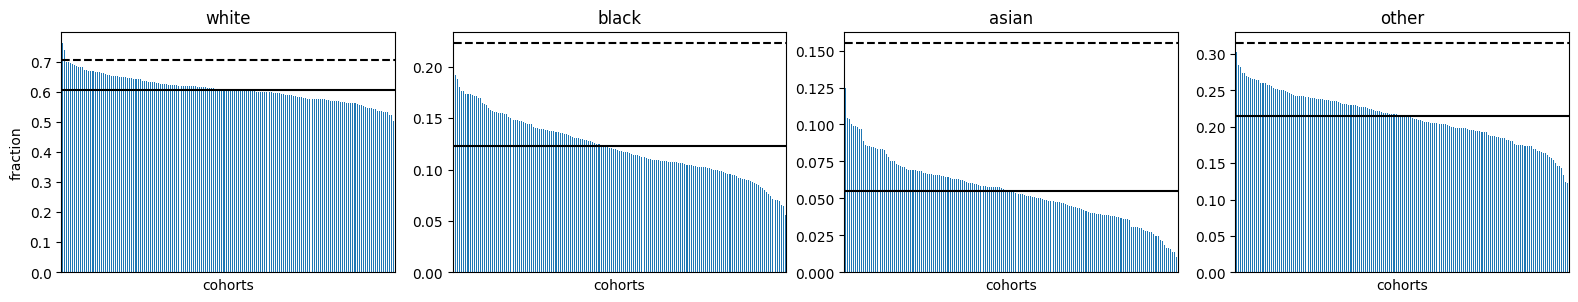

In [22]:
# sanity check we did this right.

# choose some random panel id
panel_id = random.choice(panel_ids)
print('inspecting panel id = %s' % panel_id)
panel_df = all_panels_cohort_df[all_panels_cohort_df.panel_id==panel_id]

for k in k_values:
    print('\n-----------\nk=%s\n' % k)
    cohort_name = 'cohort_k%s'%k
    show_panel_info(panel_df, cohort_name=cohort_name)


### save cohorts output

In [23]:
comscore_acs_race_panels_cohorts_fpath = '../output/comscore_acs_race_panels_cohorts.csv'

In [24]:
print('saving to %s...' % comscore_acs_race_panels_cohorts_fpath)
all_panels_cohort_df.to_csv(comscore_acs_race_panels_cohorts_fpath, index=False)

saving to ../output/comscore_acs_race_panels_cohorts.csv...


In [25]:
# script re-entry
comscore_acs_race_panels_cohorts_fpath = '../output/comscore_acs_race_panels_cohorts.csv'
all_panels_cohort_df = pd.read_csv(comscore_acs_race_panels_cohorts_fpath)
all_panels_cohort_df.head()

,machine_id,week,n_domains,racial_background,stratify,panel_id,simhash,cohort,cohort_k30,cohort_k32,cohort_k35,cohort_k40,cohort_k50,cohort_k100
0,216368766,1,76,1.0,1,1,365749827549635,156,170,156,137,120,92,52
1,225562713,1,22,1.0,1,1,207360132440987,90,97,90,80,71,52,31
2,193448730,1,209,1.0,1,1,298786899639816,125,137,125,111,97,73,43
3,216306558,1,17,1.0,1,1,463655815244049,192,207,192,169,144,113,64
4,223440886,1,7,1.0,1,1,308745029242759,128,141,128,114,100,76,45


---

## Comparison FLoC assignments

Here we create a comparison/counterfactual to the true panel data.

The same machine_ids for panels are used as for the true data, but where only the sample's demographics are kept.

### Method 1: Randomly assigned domains

The visited sets of domains are randomly assigned to panel samples, but where domains are assigned in a way proportional to how they occur in the real panel data.

With this creation, domain visits and therefore cohorts should not be correlated with demographics.


Here's how we do this:

- first take the real panel data, where panel samples are joined with their true sessions data, and data is then limited to samples with >= 7 domains per sample.

- take the distribution of n_domains 

- take the distribution of domains, using each domain's frequency of occurance in the real samples.
i.e. when domains are randomly sampled, their sampling weight is proportional to the number of samples for which they occur in the real panel data.

Create data where
- each machine,week sample from the real panel is assigned a set of domains by randomly sampling from the distribution of n_domains and the distribution of domains
- simhash and cohorts are computed and assigned as the same way for the true panel data.

---

Read in the sessions data and join with the panel data as and make the distributions to randomly sample the fake panel data from:
- n_domains distribution
- domains distribution

In [26]:
# read in the pre-processed sessions data 
# this maps week,machine_id -> domains set
weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'
weeks_machines_domains_df = read_weeks_machines_domains(weeks_machines_domains_fpath)
weeks_machines_domains_df.drop(['machine_id', 'domains'], axis=1).head()

reading from ../output/weeks_machines_domains.csv...
... read 4877236 rows


,week,n_domains
0,1,104
1,1,0
2,1,20
3,1,49
4,1,64


Read in the panels data (again) and repeat the steps above.

In [27]:
comscore_acs_race_panels_fpath = '../output/comscore_acs_race_panels.csv'
all_panels_df = pd.read_csv(comscore_acs_race_panels_fpath)
print('read in all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())

all_panels_df['domains'] = all_panels_df.set_index(
    ['machine_id','week']
).index.map(weeks_machines_domains_df.set_index(['machine_id','week'])['domains'])

all_panels_df.drop(['machine_id', 'domains'], axis=1).head()

read in all panels: 12568740 total rows
520 panels


,week,n_domains,racial_background,stratify,panel_id
0,1,76,1.0,1,1
1,1,22,1.0,1,1
2,1,209,1.0,1,1
3,1,17,1.0,1,1
4,1,7,1.0,1,1


In [28]:
n_domains_distribution = all_panels_df.n_domains

# make a list of all domains where the frequency they appear in the list
# is the same as the frequency which they appear in the panel samples
# weekly domains sets
domains_sets = all_panels_df.domains.to_list()
domains = [d for domain_set in domains_sets for d in domain_set]
# check this matches the n_domains distribution data
assert(len(domains) == n_domains_distribution.sum())

In [29]:
# transform that list into the map: {domain: frequency}
domains_distribution_map = {d: 0 for d in set(domains)}
print('%s unique domains' % len(domains_distribution_map))
for d in domains:
    domains_distribution_map[d] += 1
# and then trandform this into 2 series:
# domains_list has an item for each domain
# and domains_p is a list of corresponding the probabilities (weights) 
# for each domain in domains_p where the indices match
domains_list = list(domains_distribution_map.keys())
domains_p = [v/len(domains) for v in domains_distribution_map.values()]
assert(round((sum(domains_p)), 4) == 1)

4324794 unique domains


In [30]:
random.seed(0)

def get_random_domains_set(x):
    n_domains = random.choice(n_domains_distribution)
    return set(random.sample(
        domains,
        k=n_domains,
    ))

Create alternative version of panel by copying true panel and reassigning domains using computed distributions.

In [31]:
all_panels_random_domains_df = all_panels_df.copy().drop(
    ['n_domains', 'domains'], axis=1
)
all_panels_random_domains_df.head()

,machine_id,week,racial_background,stratify,panel_id
0,216368766,1,1.0,1,1
1,225562713,1,1.0,1,1
2,193448730,1,1.0,1,1
3,216306558,1,1.0,1,1
4,223440886,1,1.0,1,1


In [32]:
# how long will this take?
print('%s total samples across panels' % len(all_panels_random_domains_df))

# how long with just N samples?
N = 100000
start_time = datetime.now()
N_all_panels_random_domains_df = all_panels_random_domains_df.head(N).copy()
N_all_panels_random_domains_df['domains'] = N_all_panels_random_domains_df.apply(get_random_domains_set, axis=1)
N_all_panels_random_domains_df['n_domains'] = N_all_panels_random_domains_df.domains.apply(len)
end_time = datetime.now()
time = end_time - start_time
print('took %s for %s samples' % (time, N))
N_all_panels_random_domains_df.head()

12568740 total samples across panels
took 0:00:33.424551 for 100000 samples


,machine_id,week,racial_background,stratify,panel_id,domains,n_domains
0,216368766,1,1.0,1,1,"{atlantadoor.com, sonyentertainmentnetwork.com...",46
1,225562713,1,1.0,1,1,"{milwaukee.gov, contentspread.net, georgia.gov...",71
2,193448730,1,1.0,1,1,"{movierulz.mn, backpage.com, wixonjewelers.com...",11
3,216306558,1,1.0,1,1,"{rightbrainnews.com, gamesanalytics.net, youtu...",12
4,223440886,1,1.0,1,1,"{susd5.org, easel.ly, completehomeconcepts.com...",35


In [33]:
# how many minutes will this take?
s = 65
print('how many minutes might this take for the entire set of samples?')
len(all_panels_random_domains_df)/N * (s/60) # took about so many seconds with N

how many minutes might this take for the entire set of samples?


136.16135

In [34]:
all_panels_random_domains_df['domains'] = all_panels_random_domains_df.apply(get_random_domains_set, axis=1)
all_panels_random_domains_df['n_domains'] = all_panels_random_domains_df.domains.apply(len)
all_panels_random_domains_df.head()

,machine_id,week,racial_background,stratify,panel_id,domains,n_domains
0,216368766,1,1.0,1,1,"{usedprice.com, thespringsla.com, costco.com, ...",65
1,225562713,1,1.0,1,1,"{ojrq.net, youtube.com, mercurynews.com, goodf...",18
2,193448730,1,1.0,1,1,"{nbcunicareers.com, nnerenmls.com, messenger.c...",33
3,216306558,1,1.0,1,1,"{adblockplus.org, homestead.com, parcalpharett...",7
4,223440886,1,1.0,1,1,"{twitter.com, intuit.com, theantimedia.org, ga...",12


Compute simhash on domains sets

In [35]:
# how long might this take?
start_time = datetime.now()
N_all_panels_random_domains_df['simhash'] = N_all_panels_random_domains_df.domains.apply(floc.hashes.sim_hash_string)
end_time = datetime.now()
time = end_time - start_time
print('took %s for %s samples' % (time, N))
N_all_panels_random_domains_df.head()

took 0:01:16.411235 for 100000 samples


,machine_id,week,racial_background,stratify,panel_id,domains,n_domains,simhash
0,216368766,1,1.0,1,1,"{atlantadoor.com, sonyentertainmentnetwork.com...",46,817412702864348
1,225562713,1,1.0,1,1,"{milwaukee.gov, contentspread.net, georgia.gov...",71,1047413757723388
2,193448730,1,1.0,1,1,"{movierulz.mn, backpage.com, wixonjewelers.com...",11,128524691985590
3,216306558,1,1.0,1,1,"{rightbrainnews.com, gamesanalytics.net, youtu...",12,1044169598598940
4,223440886,1,1.0,1,1,"{susd5.org, easel.ly, completehomeconcepts.com...",35,628575527278345


In [36]:
# how many minutes will this take?
s = 43
print('how many minutes might this take for the entire set of samples?')
len(all_panels_random_domains_df)/N * (s/60) # took about so many seconds with N

how many minutes might this take for the entire set of samples?


90.07597

In [37]:
# apply simhash (expect >90 mins to run)
start_t = datetime.now()
all_panels_random_domains_df['simhash'] = all_panels_random_domains_df.domains.apply(floc.hashes.sim_hash_string)
print('time to compute simhash for all samples:  %s' % (datetime.now() - start_t))
all_panels_random_domains_df.head()

time to compute simhash for all samples:  1:28:07.105322


,machine_id,week,racial_background,stratify,panel_id,domains,n_domains,simhash
0,216368766,1,1.0,1,1,"{usedprice.com, thespringsla.com, costco.com, ...",65,6116004992641
1,225562713,1,1.0,1,1,"{ojrq.net, youtube.com, mercurynews.com, goodf...",18,151081662842134
2,193448730,1,1.0,1,1,"{nbcunicareers.com, nnerenmls.com, messenger.c...",33,837936008895539
3,216306558,1,1.0,1,1,"{adblockplus.org, homestead.com, parcalpharett...",7,85242338771832
4,223440886,1,1.0,1,1,"{twitter.com, intuit.com, theantimedia.org, ga...",12,558651868531350


#### Save intermediary output: panels with simhash

This also makes the data *MUCH* size smaller by dropping the domains.

In [38]:
comscore_acs_race_panels_random_simhash_fpath = '../output/comscore_acs_race_panels_random_simhash.csv'

In [39]:
print('saving to %s...' % comscore_acs_race_panels_random_simhash_fpath)
all_panels_random_domains_df.drop('domains', axis=1).to_csv(comscore_acs_race_panels_random_simhash_fpath, index=False)
print('...saved')

saving to ../output/comscore_acs_race_panels_random_simhash.csv...
...saved


#### Script re-entry point

In [40]:
all_panels_random_domains_df = pd.read_csv(comscore_acs_race_panels_random_simhash_fpath)
print('read in all panels data: %s total rows' % len(all_panels_random_domains_df))
print('%s panels' % all_panels_random_domains_df.panel_id.nunique())
all_panels_random_domains_df.head()

read in all panels data: 12568740 total rows
520 panels


,machine_id,week,racial_background,stratify,panel_id,n_domains,simhash
0,216368766,1,1.0,1,1,65,6116004992641
1,225562713,1,1.0,1,1,18,151081662842134
2,193448730,1,1.0,1,1,33,837936008895539
3,216306558,1,1.0,1,1,7,85242338771832
4,223440886,1,1.0,1,1,12,558651868531350


### Compute cohorts for each panel

Use the same k values as for the real data and then compare. The comparison is a sanity check, not analysis. Analysis is later.

In [41]:
k = 32

# panel_ids = all_panels_random_domains_df.panel_id.unique() <-- already set above for real data

panel_dfs = Parallel(n_jobs=N_JOBS, verbose=True)(delayed(assign_cohorts)(
    all_panels_random_domains_df, panel_id, k=k) for panel_id in panel_ids)

all_panels_random_domains_cohort_df = pd.concat(panel_dfs)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   46.8s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  1.9min finished


In [42]:
# Also compute cohort IDs for other k, for experimentation later
# k_values = [30, 32, 35, 40, 50, 100]  <-- already set above
# add another column for each k, iteratively
for k in k_values:
    cohort_name = 'cohort_k%s'%k
    print('assigning cohorts for k=%s (%s)' % (k, cohort_name))
    panel_dfs = Parallel(n_jobs=N_JOBS, verbose=True)(delayed(assign_cohorts)(
        all_panels_random_domains_cohort_df, panel_id, k=k, cohort_name=cohort_name
    ) for panel_id in panel_ids)
    all_panels_random_domains_cohort_df = pd.concat(panel_dfs)

assigning cohorts for k=30 (cohort_k30)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   32.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.8min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  4.5min finished


assigning cohorts for k=32 (cohort_k32)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   23.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  4.5min finished


assigning cohorts for k=35 (cohort_k35)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   26.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  4.9min finished


assigning cohorts for k=40 (cohort_k40)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   28.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.5min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  5.3min finished


assigning cohorts for k=50 (cohort_k50)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   30.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.9min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  5.8min finished


assigning cohorts for k=100 (cohort_k100)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   36.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  5.2min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  6.2min finished


In [43]:
all_panels_random_domains_cohort_df.head()

,machine_id,week,racial_background,stratify,panel_id,n_domains,simhash,cohort,cohort_k30,cohort_k32,cohort_k35,cohort_k40,cohort_k50,cohort_k100
0,216368766,1,1.0,1,1,65,6116004992641,4,4,4,3,2,2,2
1,225562713,1,1.0,1,1,18,151081662842134,67,71,67,58,52,40,23
2,193448730,1,1.0,1,1,33,837936008895539,386,407,386,344,299,231,130
3,216306558,1,1.0,1,1,7,85242338771832,39,41,39,36,32,24,14
4,223440886,1,1.0,1,1,12,558651868531350,235,248,235,206,180,146,80


Compare values to true data

inspecting panel id = 216

-----------
k=30

580 total cohorts
|C| / k = 19.333
cohort sizes:
count    580.000000
mean      46.418966
std       11.887294
min       30.000000
25%       37.000000
50%       44.000000
75%       54.000000
max       93.000000
Name: cohort_k30, dtype: float64


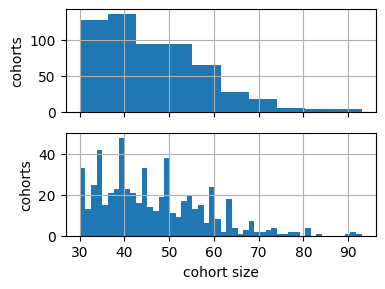

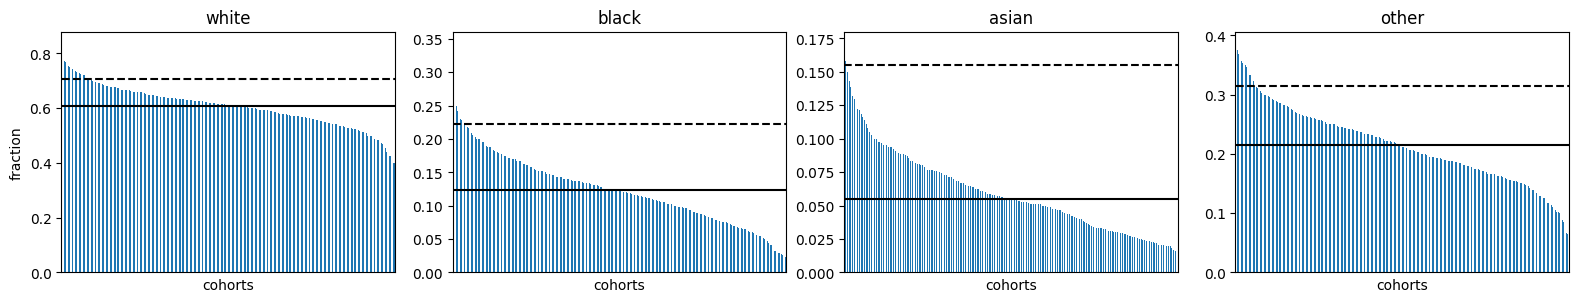


-----------
k=32

550 total cohorts
|C| / k = 17.188
cohort sizes:
count    550.000000
mean      48.950909
std       12.586435
min       32.000000
25%       39.000000
50%       47.000000
75%       57.000000
max       93.000000
Name: cohort_k32, dtype: float64


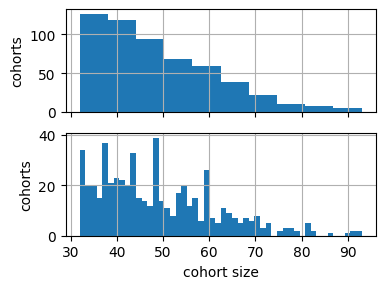

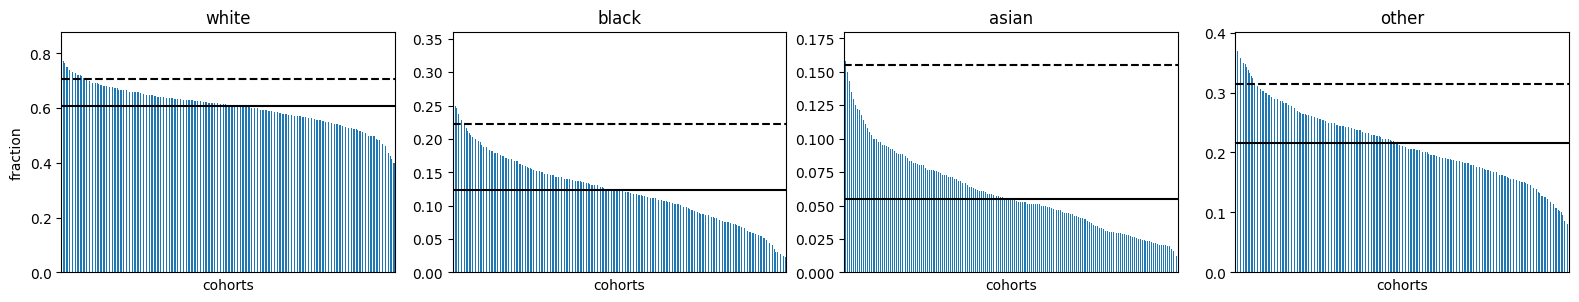


-----------
k=35

501 total cohorts
|C| / k = 14.314
cohort sizes:
count    501.000000
mean      53.738523
std       14.841614
min       35.000000
25%       41.000000
50%       50.000000
75%       63.000000
max      114.000000
Name: cohort_k35, dtype: float64


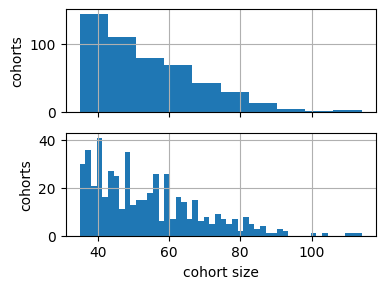

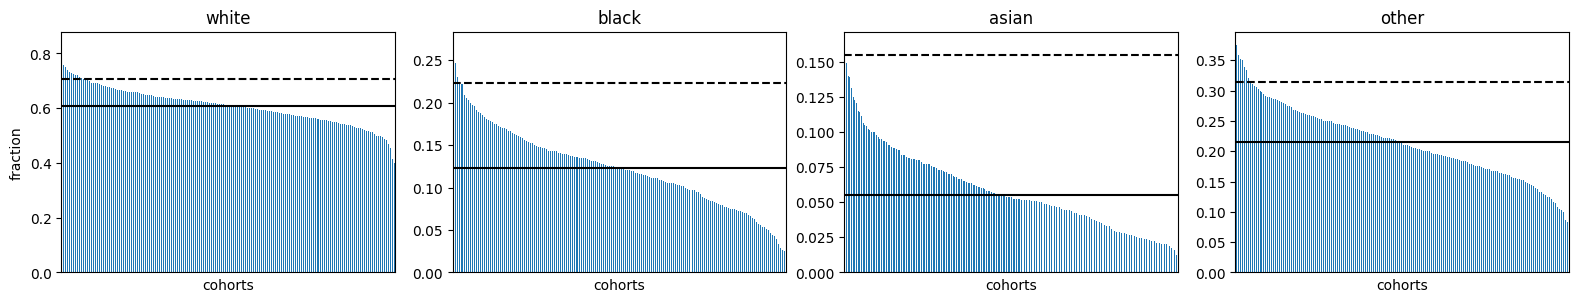


-----------
k=40

425 total cohorts
|C| / k = 10.625
cohort sizes:
count    425.000000
mean      63.348235
std       18.311409
min       40.000000
25%       48.000000
50%       60.000000
75%       77.000000
max      122.000000
Name: cohort_k40, dtype: float64


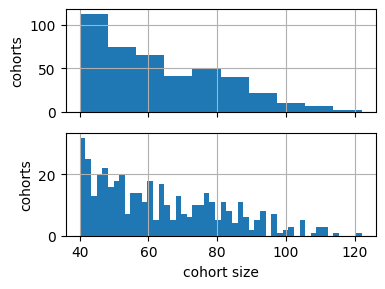

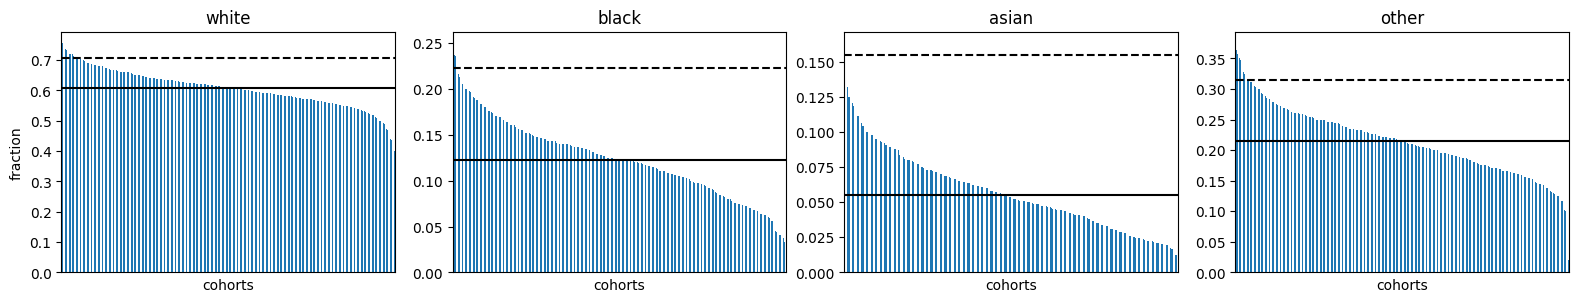


-----------
k=50

321 total cohorts
|C| / k = 6.420
cohort sizes:
count    321.000000
mean      83.872274
std       21.460266
min       50.000000
25%       66.000000
50%       84.000000
75%      100.000000
max      144.000000
Name: cohort_k50, dtype: float64


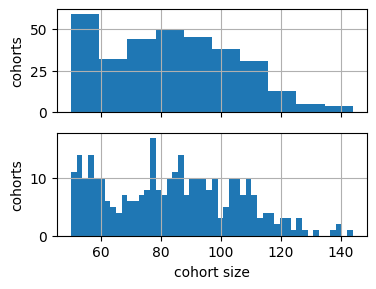

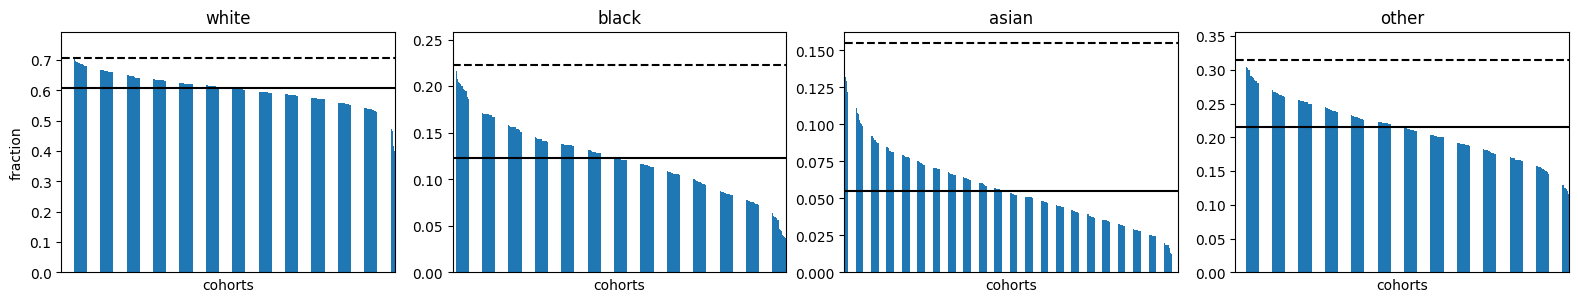


-----------
k=100

182 total cohorts
|C| / k = 1.820
cohort sizes:
count    182.000000
mean     147.928571
std       33.601999
min      100.000000
25%      117.250000
50%      141.500000
75%      176.000000
max      218.000000
Name: cohort_k100, dtype: float64


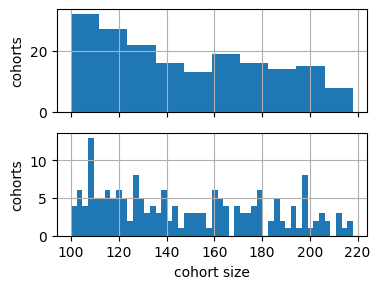

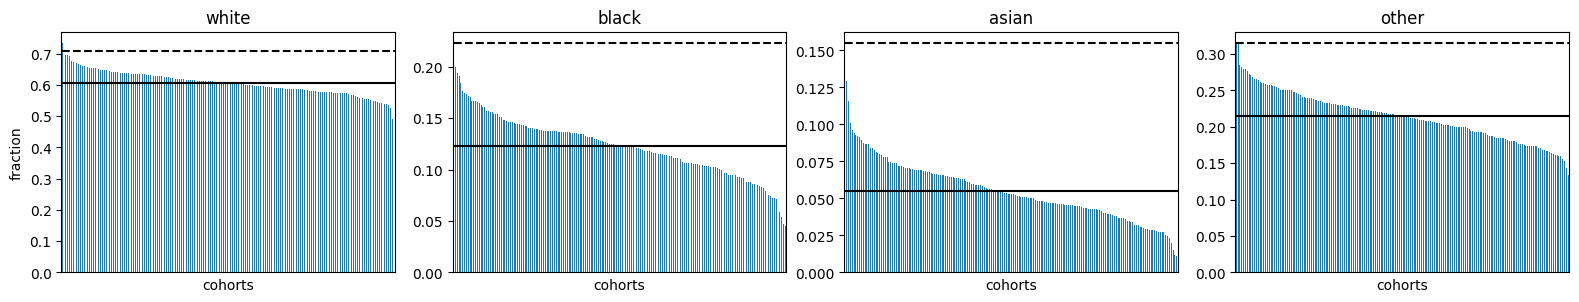

In [44]:
# sanity check we did this right.
# choose some random panel id
panel_id = random.choice(panel_ids)
print('inspecting panel id = %s' % panel_id)
panel_df = all_panels_random_domains_cohort_df[
    (all_panels_random_domains_cohort_df.panel_id==panel_id)
]
for k in k_values:
    print('\n-----------\nk=%s\n' % k)
    cohort_name = 'cohort_k%s'%k
    show_panel_info(panel_df, cohort_name=cohort_name)

### Save output to file

In [45]:
comscore_acs_race_panels_random_cohorts_fpath = '../output/comscore_acs_race_panels_random_cohorts.csv'

In [46]:
print('saving to %s...' % comscore_acs_race_panels_random_cohorts_fpath)
all_panels_random_domains_cohort_df.to_csv(comscore_acs_race_panels_random_cohorts_fpath, index=False)
print('...saved')

saving to ../output/comscore_acs_race_panels_random_cohorts.csv...
...saved


#### Script re-entry

In [3]:
# script re-entry
comscore_acs_race_panels_cohorts_fpath = '../output/comscore_acs_race_panels_cohorts.csv'
all_panels_cohort_df = pd.read_csv(comscore_acs_race_panels_cohorts_fpath)
print('read in %s rows of true panel cohorts data' % len(all_panels_cohort_df))
all_panels_cohort_df.head()

read in 12568740 rows of true panel cohorts data


,machine_id,week,n_domains,racial_background,stratify,panel_id,simhash,cohort,cohort_k30,cohort_k32,cohort_k35,cohort_k40,cohort_k50,cohort_k100
0,216368766,1,76,1.0,1,1,365749827549635,156,170,156,137,120,92,52
1,225562713,1,22,1.0,1,1,207360132440987,90,97,90,80,71,52,31
2,193448730,1,209,1.0,1,1,298786899639816,125,137,125,111,97,73,43
3,216306558,1,17,1.0,1,1,463655815244049,192,207,192,169,144,113,64
4,223440886,1,7,1.0,1,1,308745029242759,128,141,128,114,100,76,45


In [4]:
comscore_acs_race_panels_random_cohorts_fpath = '../output/comscore_acs_race_panels_random_cohorts.csv'
all_panels_random_domains_cohort_df = pd.read_csv(comscore_acs_race_panels_random_cohorts_fpath)
print(
    'read in %s rows of panel with randomly assigned domains, cohorts data' \
    % len(all_panels_random_domains_cohort_df))
all_panels_random_domains_cohort_df.head()

read in 12568740 rows of panel with randomly assigned domains, cohorts data


,machine_id,week,racial_background,stratify,panel_id,n_domains,simhash,cohort,cohort_k30,cohort_k32,cohort_k35,cohort_k40,cohort_k50,cohort_k100
0,216368766,1,1.0,1,1,65,6116004992641,4,4,4,3,2,2,2
1,225562713,1,1.0,1,1,18,151081662842134,67,71,67,58,52,40,23
2,193448730,1,1.0,1,1,33,837936008895539,386,407,386,344,299,231,130
3,216306558,1,1.0,1,1,7,85242338771832,39,41,39,36,32,24,14
4,223440886,1,1.0,1,1,12,558651868531350,235,248,235,206,180,146,80


#### Panel size comparison: Evaluate how well the randomly assigned domains data represents true data

w.r.t. size

This is important because the distribution of how many cohorts violate t-closeness is dependent on cohort size.

### Panel size comparison

Make a table for visual and correlation analysis:

```
panel_id, panel_size, avg_cohort_size, avg_random_domains_cohort_size
```

In [5]:
def compare_panel_cohort_sizes(true_df, other_df, 
                               other_avg_cohort_size_name):
    """
    Returns a dataframe with columns
    panel_id, panel_size, avg_cohort_size, other_avg_cohort_size_name
    
    where:
        - the input dfs have same panel ids but different 
        cohort assignments
        - avg_cohort_size, other_avg_cohort_size_name represent 
        mean cohort size for given panel_id
    """
    panel_sizes = true_df.groupby(
        'panel_id'
    ).size().rename('panel_size').to_frame()
    panel_sizes['avg_cohort_size'] = true_df.groupby(
        ['panel_id', 'cohort']
    ).size().rename('size').reset_index().groupby(
        ['panel_id']
    ).agg({'size': [np.mean]})
    panel_sizes[other_avg_cohort_size_name] = other_df.groupby(
        ['panel_id', 'cohort']
    ).size().rename('size').reset_index().groupby(
        ['panel_id']
    ).agg({'size': [np.mean]})
    return panel_sizes

In [9]:
other_avg_cohort_size_name = 'avg_random_domains_cohort_size'

panel_sizes = compare_panel_cohort_sizes(
    all_panels_cohort_df, all_panels_random_domains_cohort_df, 
    other_avg_cohort_size_name)
panel_sizes.head()

,panel_size,avg_cohort_size,avg_random_domains_cohort_size
panel_id,,,
1,25900,51.696607,49.521989
2,26334,51.736739,49.130597
3,27719,51.331481,49.060177
4,25943,51.989980,48.856874
5,27334,50.431734,48.550622


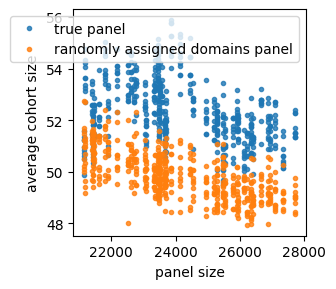

In [26]:
# plot the compared panel cohort sizes

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=100)
panel_sizes_sorted = panel_sizes.sort_values('panel_size')
ax.plot(
    panel_sizes_sorted['panel_size'],
    panel_sizes_sorted['avg_cohort_size'], '.', 
    alpha=0.8,
    label='true panel'
)
ax.plot(
    panel_sizes_sorted['panel_size'],
    panel_sizes_sorted[other_avg_cohort_size_name], '.',
    alpha=0.8,
    label='randomly assigned domains panel'
)
ax.set_ylabel('average cohort size')
ax.set_xlabel('panel size')
_ = ax.legend()

Clearly the randomly assigned domains data does not well represent the true data.

We need an alternative method.

Below we instead simply randomly shuffle the simhash values among the panel.

## Method 2: Randomly shuffled simhashes

Steps to make this alternative cohorts assignment data:
1. copy the real panels and simhash data
2. randomly shuffle the simhash values across the samples
3. compute cohorts

In [28]:
all_panels_randomly_shuffled_simhash_cohorts_df = all_panels_cohort_df[[
    'machine_id', 'week', 'racial_background', 'panel_id', 'simhash'
]].copy()
all_panels_randomly_shuffled_simhash_cohorts_df.head()

,machine_id,week,racial_background,panel_id,simhash
0,216368766,1,1.0,1,365749827549635
1,225562713,1,1.0,1,207360132440987
2,193448730,1,1.0,1,298786899639816
3,216306558,1,1.0,1,463655815244049
4,223440886,1,1.0,1,308745029242759


Randomly shuffle the simhash values

In [50]:
random.seed(0)

simhash_values = all_panels_randomly_shuffled_simhash_cohorts_df.simhash.values
random.shuffle(simhash_values)
all_panels_randomly_shuffled_simhash_cohorts_df.simhash = simhash_values
all_panels_randomly_shuffled_simhash_cohorts_df.head()

,machine_id,week,racial_background,panel_id,simhash
0,216368766,1,1.0,1,1090102657990507
1,225562713,1,1.0,1,1019338229492379
2,193448730,1,1.0,1,734410134560674
3,216306558,1,1.0,1,678452071939058
4,223440886,1,1.0,1,1030473222958166


Assign cohorts

In [54]:
k = 32

panel_ids = all_panels_randomly_shuffled_simhash_cohorts_df.panel_id.unique() #<-- already set above for real data

panel_dfs = Parallel(n_jobs=N_JOBS, verbose=True)(delayed(assign_cohorts)(
    all_panels_randomly_shuffled_simhash_cohorts_df, panel_id, k=k
) for panel_id in panel_ids)

all_panels_randomly_shuffled_simhash_cohorts_df = pd.concat(panel_dfs)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   41.6s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  2.0min finished


In [56]:
# Also compute cohort IDs for other k, for experimentation later
k_values = [30, 32, 35, 40, 50, 100] #  <-- already set above
# add another column for each k, iteratively
for k in k_values:
    cohort_name = 'cohort_k%s'%k
    print('assigning cohorts for k=%s (%s)' % (k, cohort_name))
    panel_dfs = Parallel(n_jobs=N_JOBS, verbose=True)(delayed(assign_cohorts)(
        all_panels_randomly_shuffled_simhash_cohorts_df, panel_id, k=k, cohort_name=cohort_name
    ) for panel_id in panel_ids)
    all_panels_randomly_shuffled_simhash_cohorts_df = pd.concat(panel_dfs)

assigning cohorts for k=30 (cohort_k30)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   23.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  4.1min finished


assigning cohorts for k=32 (cohort_k32)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   21.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  4.3min finished


assigning cohorts for k=35 (cohort_k35)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   22.9s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.8min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  4.4min finished


assigning cohorts for k=40 (cohort_k40)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   24.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  4.8min finished


assigning cohorts for k=50 (cohort_k50)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   28.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.5min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  5.2min finished


assigning cohorts for k=100 (cohort_k100)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   28.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.7min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  5.6min finished


In [58]:
all_panels_randomly_shuffled_simhash_cohorts_df.head()

,machine_id,week,racial_background,panel_id,simhash,cohort,cohort_k30,cohort_k32,cohort_k35,cohort_k40,cohort_k50,cohort_k100
0,216368766,1,1.0,1,1090102657990507,485,521,485,448,384,302,164
1,225562713,1,1.0,1,1019338229492379,447,479,447,414,356,278,152
2,193448730,1,1.0,1,734410134560674,297,322,297,273,231,178,103
3,216306558,1,1.0,1,678452071939058,265,286,265,244,204,162,93
4,223440886,1,1.0,1,1030473222958166,456,488,456,423,362,283,155


### Save output to file

In [59]:
comscore_acs_race_panels_randomly_shuffled_simhash_cohorts_fpath = '../output/comscore_acs_race_panels_randomly_shuffled_simhash_cohorts.csv'

In [60]:
print('saving to %s...' % comscore_acs_race_panels_randomly_shuffled_simhash_cohorts_fpath)
all_panels_randomly_shuffled_simhash_cohorts_df.to_csv(
    comscore_acs_race_panels_randomly_shuffled_simhash_cohorts_fpath, 
    index=False)
print('...saved')

saving to ../output/comscore_acs_race_panels_randomly_shuffled_simhash_cohorts.csv...
...saved


Inspect

inspecting panel id = 317

-----------
k=30

588 total cohorts
|C| / k = 19.600
cohort sizes:
count    588.000000
mean      46.486395
std       12.537296
min       30.000000
25%       36.000000
50%       44.000000
75%       55.000000
max       91.000000
Name: cohort_k30, dtype: float64


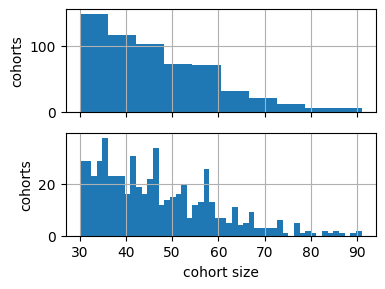

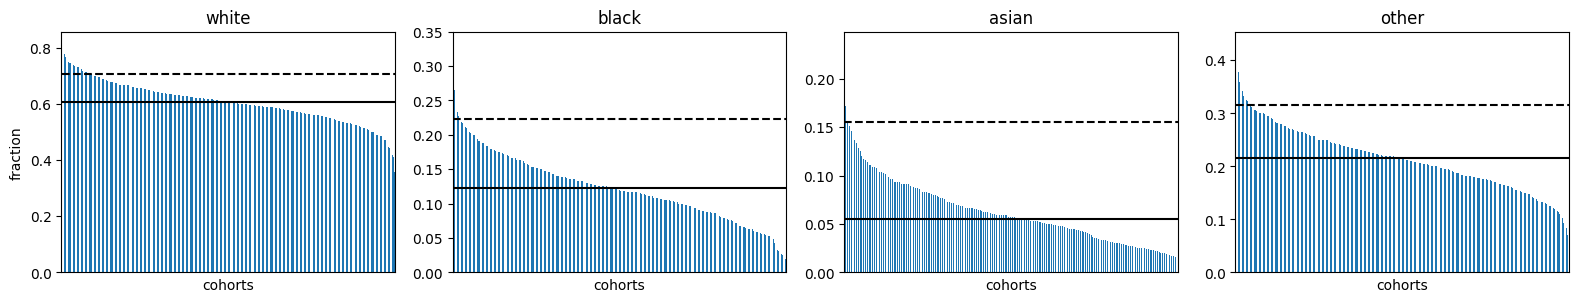


-----------
k=32

560 total cohorts
|C| / k = 17.500
cohort sizes:
count    560.000000
mean      48.810714
std       13.511271
min       32.000000
25%       38.000000
50%       46.000000
75%       57.000000
max      104.000000
Name: cohort_k32, dtype: float64


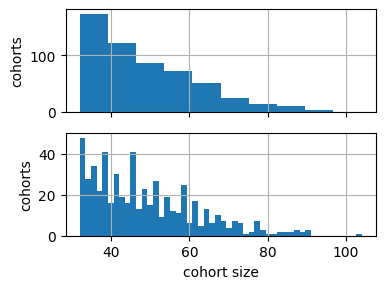

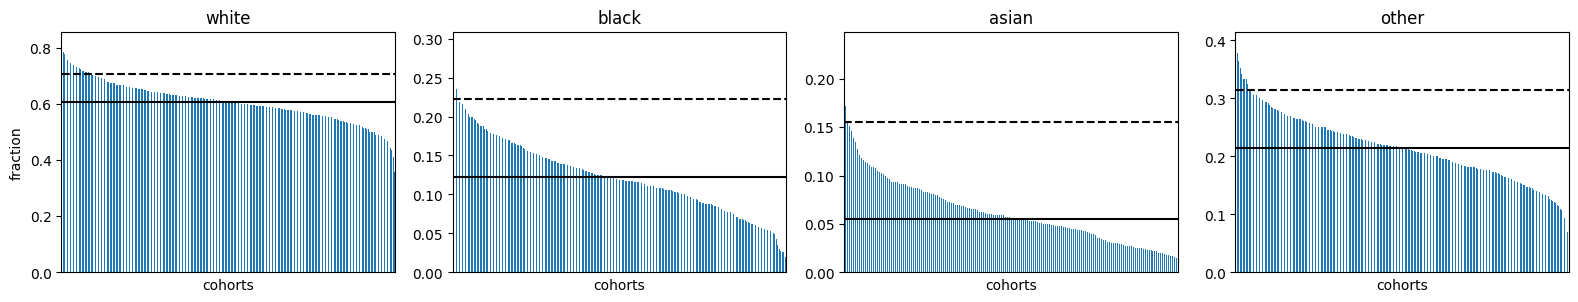


-----------
k=35

497 total cohorts
|C| / k = 14.200
cohort sizes:
count    497.000000
mean      54.997988
std       15.086778
min       35.000000
25%       43.000000
50%       51.000000
75%       66.000000
max      104.000000
Name: cohort_k35, dtype: float64


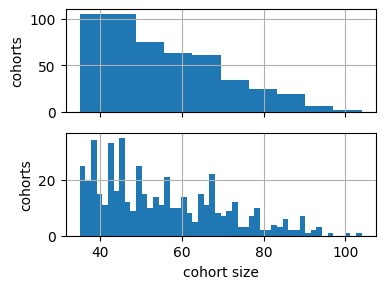

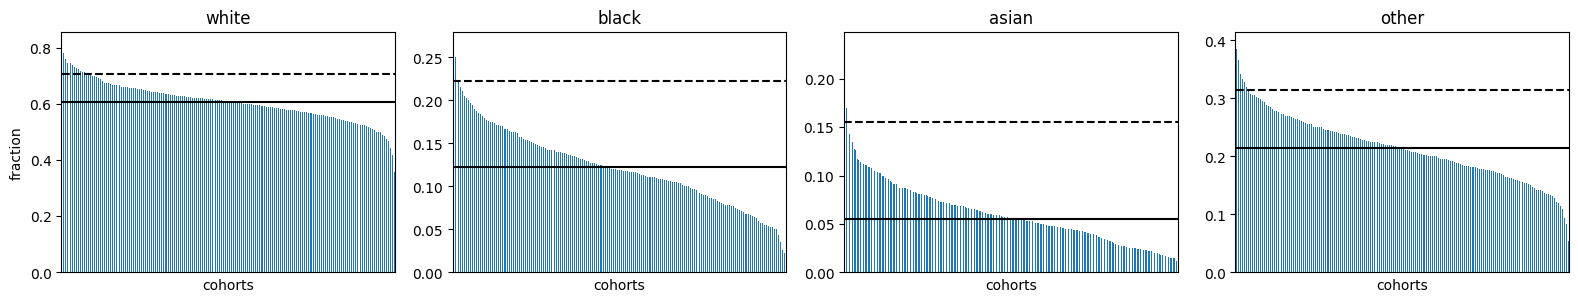


-----------
k=40

427 total cohorts
|C| / k = 10.675
cohort sizes:
count    427.000000
mean      64.014052
std       17.865559
min       40.000000
25%       49.000000
50%       62.000000
75%       77.000000
max      126.000000
Name: cohort_k40, dtype: float64


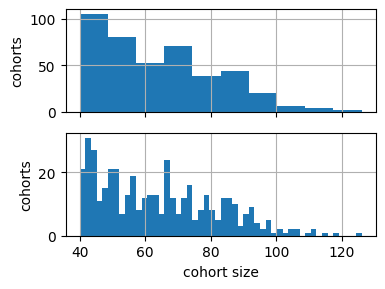

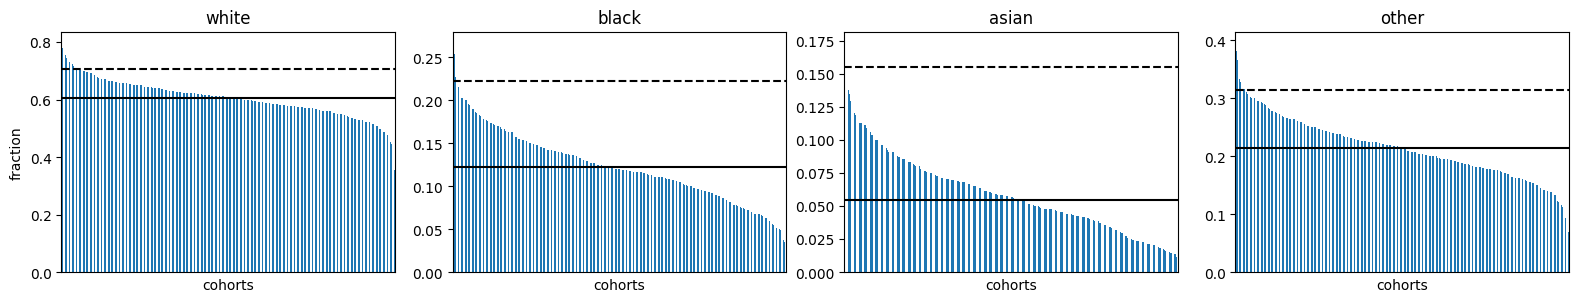


-----------
k=50

332 total cohorts
|C| / k = 6.640
cohort sizes:
count    332.000000
mean      82.331325
std       20.884342
min       50.000000
25%       66.000000
50%       82.500000
75%       97.000000
max      161.000000
Name: cohort_k50, dtype: float64


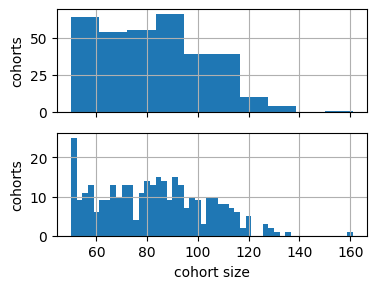

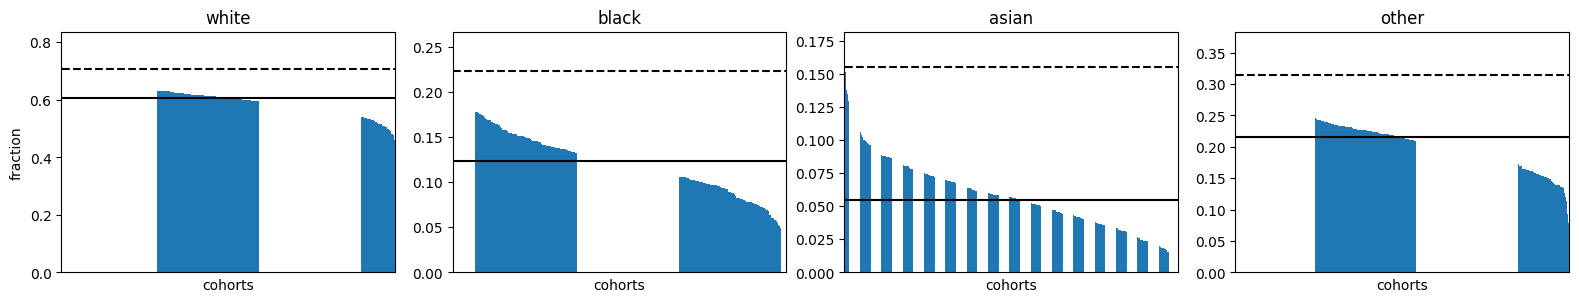


-----------
k=100

180 total cohorts
|C| / k = 1.800
cohort sizes:
count    180.000000
mean     151.855556
std       33.591220
min      100.000000
25%      122.750000
50%      147.500000
75%      179.250000
max      226.000000
Name: cohort_k100, dtype: float64


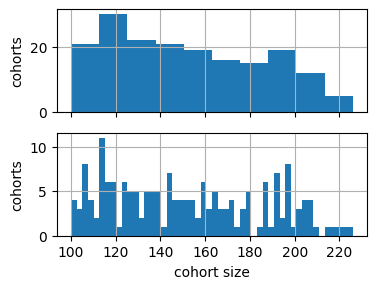

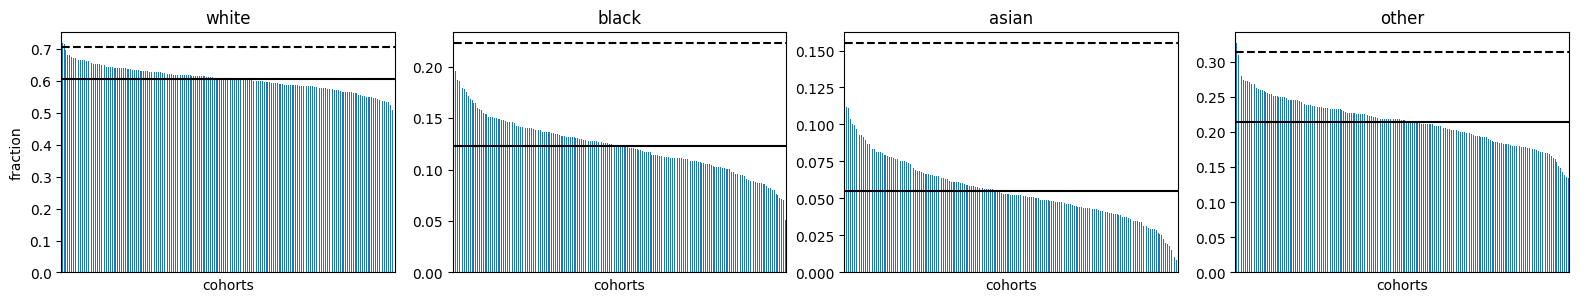

In [65]:
# sanity check we did this right.
# choose some random panel id
panel_id = random.choice(panel_ids)
print('inspecting panel id = %s' % panel_id)
panel_df = all_panels_random_domains_cohort_df[
    (all_panels_randomly_shuffled_simhash_cohorts_df.panel_id==panel_id)
]
for k in k_values:
    print('\n-----------\nk=%s\n' % k)
    cohort_name = 'cohort_k%s'%k
    show_panel_info(panel_df, cohort_name=cohort_name)

### Panel size comparison

,panel_size,avg_cohort_size,avg_randomly_shuffled_simhash_cohort_size
panel_id,,,
291,21152,51.590244,52.616915
83,21152,50.846154,51.843137
135,21152,50.482100,53.549367
187,21152,51.215496,53.012531
239,21152,50.602871,52.748130


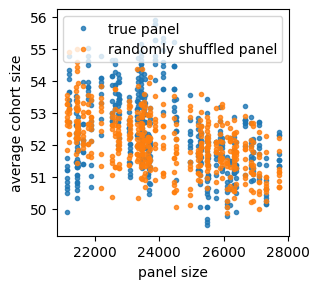

In [66]:
other_avg_cohort_size_name = 'avg_randomly_shuffled_simhash_cohort_size'

panel_sizes = compare_panel_cohort_sizes(
    all_panels_cohort_df,
    all_panels_randomly_shuffled_simhash_cohorts_df, 
    other_avg_cohort_size_name)

# plot the compared panel cohort sizes

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=100)
panel_sizes_sorted = panel_sizes.sort_values('panel_size')
ax.plot(
    panel_sizes_sorted['panel_size'],
    panel_sizes_sorted['avg_cohort_size'], '.', 
    alpha=0.8,
    label='true panel'
)
ax.plot(
    panel_sizes_sorted['panel_size'],
    panel_sizes_sorted[other_avg_cohort_size_name], '.',
    alpha=0.8,
    label='randomly shuffled panel'
)
ax.set_ylabel('average cohort size')
ax.set_xlabel('panel size')
_ = ax.legend()

panel_sizes_sorted.head()

That looks better! We use the randomly shuffled simhash cohorts data as the comparison to the true data.